In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import json
from doclayout_yolo import YOLOv10 # https://github.com/opendatalab/DocLayout-YOLO
from geojson import Feature, FeatureCollection
from shapely.geometry import box, mapping
import easyocr


BASE_PATH = "data/input/"
BASE_OUTPUT_PATH = "data/output/"
model = YOLOv10(model="yolo_models/doclayout_yolo_doclaynet_imgsz1120_docsynth_pretrain.pt")
# doclayout_yolo_doclaynet_imgsz1120_docsynth_pretrain.pt
# yolo_models/doclayout_yolo_docstructbench_imgsz1024.pt

In [ ]:
def predict_layout(image_path, imgsz=1024, conf=0.2, iou=0.2, device="cpu"):
    """
    Predict layout using the YOLOv10 model.
    """
    # Perform prediction
    det_res = model.predict(
        image_path,   # Image to predict
        imgsz=1024,   # Prediction image size
        conf=conf,    # Confidence threshold
        device="cpu",  # Device to use (e.g., 'cuda:0' or 'cpu')
        iou=iou
    )

    # Annotate and save the result
    annotated_frame = det_res[0].plot(pil=True, line_width=5, font_size=20)
    file_name = os.path.basename(image_path)
    file_name = file_name.split(".")[0]
    cv2.imwrite(f"data/output/{file_name}_yolo.jpg", annotated_frame)
    plt.imshow(annotated_frame)
    plt.axis("off")
    return det_res[0]


## extract bounding boxes and crop image 
def extract_bb_crop(results, raw_image):
    bounding_boxes = []
    for bx in results.boxes.xyxy.cpu().numpy():  # xyxy format
        print(bx)
        x1, y1, x2, y2 = bx
        bounding_boxes.append((x1, y1, x2, y2))

    features = []
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        poly = box(x1, y1, x2, y2)
        feature = Feature(geometry=mapping(poly), properties={"id": i})
        features.append(feature)

    geojson_obj = FeatureCollection(features)

    # Save to file
    with open(BASE_OUTPUT_PATH + "output_boxes.geojson", "w") as f:
        json.dump(geojson_obj, f)

    image_cv = cv2.imread(raw_image)
    reader = easyocr.Reader(['en'])
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
        cropped = image_cv[y1:y2, x1:x2]
        filename = os.path.basename(raw_image)
        cv2.imwrite(BASE_OUTPUT_PATH + f"crop_{filename}_{i}.jpg", cropped)
        re_image_read = cv2.imread(BASE_OUTPUT_PATH + f"crop_{filename}_{i}.jpg")
        res_text = reader.readtext(re_image_read)
        print(res_text)
        print("--------------------")


image 1/1 /home/anup/text_book_seg/text_book_segmentation/data/input/one_side_0.tif: 1024x640 1 Picture, 820.7ms
Speed: 6.1ms preprocess, 820.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 640)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[     101.52      215.48      1675.8      2706.4]


/home/anup/anaconda3/envs/text_book_seg/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[([[np.int32(208), 0], [np.int32(316), 0], [np.int32(316), np.int32(44)], [np.int32(208), np.int32(44)]], '^Y" ', np.float64(0.17243404686450958)), ([[np.int32(933), np.int32(87)], [np.int32(1009), np.int32(87)], [np.int32(1009), np.int32(125)], [np.int32(933), np.int32(125)]], '21.', np.float64(0.9258179611093776)), ([[np.int32(12), np.int32(140)], [np.int32(44), np.int32(140)], [np.int32(44), np.int32(184)], [np.int32(12), np.int32(184)]], '8', np.float64(0.9998416963289856)), ([[np.int32(74), np.int32(126)], [np.int32(192), np.int32(126)], [np.int32(192), np.int32(176)], [np.int32(74), np.int32(176)]], 'adw', np.float64(0.2315924581251966)), ([[np.int32(220), np.int32(110)], [np.int32(377), np.int32(110)], [np.int32(377), np.int32(166)], [np.int32(220), np.int32(166)]], 'b 3/8', np.float64(0.3166845842557501)), ([[np.int32(1344), np.int32(142)], [np.int32(1374), np.int32(142)], [np.int32(1374), np.int32(176)], [np.int32(1344), np.int32(176)]], '0', np.float64(0.8381994848855925)), (

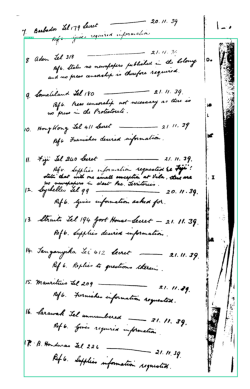

In [4]:
raw_p = BASE_PATH + "one_side_0.tif"
results = predict_layout(raw_p, conf=0.1, iou=0.5)
extract_bb_crop(results, raw_p)


image 1/1 /home/anup/text_book_seg/text_book_segmentation/data/input/one_side_1.tif: 1024x736 4 Pictures, 833.6ms
Speed: 4.3ms preprocess, 833.6ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 736)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[     50.808      1281.1      1326.5      1632.5]
[     166.89      40.174      1429.2      833.69]
[     69.888      1837.1      1421.4      1995.4]
[     45.707      918.92      1320.7      1123.9]
[([[np.int32(212), np.int32(10)], [np.int32(339), np.int32(10)], [np.int32(339), np.int32(63)], [np.int32(212), np.int32(63)]], 'nre', np.float64(0.5859364011636556)), ([[np.int32(360), np.int32(1)], [np.int32(636), np.int32(1)], [np.int32(636), np.int32(66)], [np.int32(360), np.int32(66)]], 'Bak  67', np.float64(0.12480518637562987)), ([[np.int32(1111), np.int32(37)], [np.int32(1159), np.int32(37)], [np.int32(1159), np.int32(73)], [np.int32(1111), np.int32(73)]], '76_', np.float64(0.546113110706378)), ([[np.int32(1168), np.int32(40)], [np.int32(1214), np.int32(40)], [np.int32(1214), np.int32(72)], [np.int32(1168), np.int32(72)]], 'I(.', np.float64(0.4492839316295925)), ([[np.int32(1208), np.int32(32)], [np.int32(1264), np.int32(32)], [np.int32(1264), np.int32(90)], [np.int32(1208), np.int

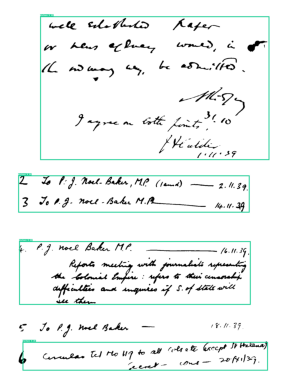

In [ ]:
#predict_layout(BASE_PATH + "one_side_1.tif", conf=0.5, iou=0.99)

raw_p = BASE_PATH + "one_side_1.tif"
results = predict_layout(raw_p, conf=0.18, iou=0.5)
extract_bb_crop(results, raw_p)


image 1/1 /home/anup/text_book_seg/text_book_segmentation/data/input/two_sides_0.JPG: 768x1024 2 Pictures, 935.5ms
Speed: 4.8ms preprocess, 935.5ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)
[     2092.5      15.776      3480.5      2944.9]
[     275.62    0.024557      1821.3      2528.2]


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[np.int32(850), np.int32(83)], [np.int32(916), np.int32(83)], [np.int32(916), np.int32(126)], [np.int32(850), np.int32(126)]], '20', np.float64(0.9999728575374494)), ([[np.int32(994), np.int32(68)], [np.int32(1057), np.int32(68)], [np.int32(1057), np.int32(130)], [np.int32(994), np.int32(130)]], '34', np.float64(0.2642958315625666)), ([[np.int32(198), np.int32(134)], [np.int32(481), np.int32(134)], [np.int32(481), np.int32(224)], [np.int32(198), np.int32(224)]], '{L79 bout', np.float64(0.24139000613638176)), ([[np.int32(131), np.int32(254)], [np.int32(239), np.int32(254)], [np.int32(239), np.int32(330)], [np.int32(131), np.int32(330)]], 'Ry 6 .', np.float64(0.385879915781281)), ([[np.int32(280), np.int32(238)], [np.int32(397), np.int32(238)], [np.int32(397), np.int32(312)], [np.int32(280), np.int32(312)]], 'g"c', np.float64(0.08082321705395877)), ([[np.int32(864), np.int32(297)], [np.int32(1071), np.int32(297)], [np.int32(1071), np.int32(357)], [np.int32(864), np.int32(357)]], '21.1

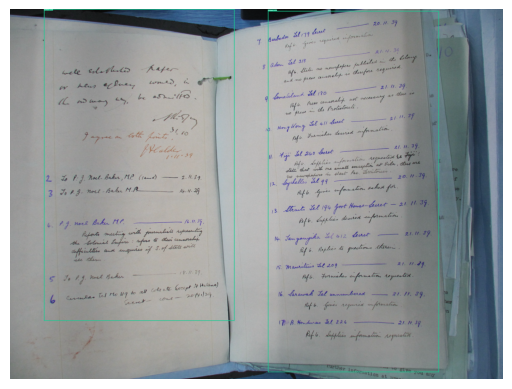

In [6]:
#predict_layout(BASE_PATH + "two_sides_0.JPG", conf=0.3)

raw_p = BASE_PATH + "two_sides_0.JPG"
results = predict_layout(raw_p, conf=0.3, iou=0.5)
extract_bb_crop(results, raw_p)


image 1/1 /home/anup/text_book_seg/text_book_segmentation/data/input/two_sides_1.JPG: 1024x768 1 Caption, 1 Picture, 1 Section-header, 13 Texts, 898.4ms
Speed: 4.6ms preprocess, 898.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 768)
[     1024.7      1363.8      2432.2      1576.5]
[       1208      1630.7      2345.8      1833.7]
[     1041.7      999.43      1403.4      1161.7]
[     1890.1       820.2      2297.6      862.66]
[     1032.8      1293.5      1208.2      1326.4]
[     1651.2      1890.6      2236.5      2039.6]
[     919.85      716.58      1293.5      848.16]
[     1053.1      877.07      1267.1      915.06]
[     947.33      630.77        1302      678.25]
[     960.46       630.5      1302.6      675.47]
[     1925.3      2085.2      2080.7      2123.4]
[     916.78      714.83      1293.2      845.73]
[     915.95      715.08      1292.3      916.88]
[     1882.3       559.9      2639.3      704.58]
[     1032.8      1293.5      1208.2      1326.

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[np.int32(93), 0], [np.int32(614), 0], [np.int32(614), np.int32(55)], [np.int32(93), np.int32(55)]], 'Following your guggestion', np.float64(0.6478579130244353)), ([[np.int32(626), np.int32(8)], [np.int32(676), np.int32(8)], [np.int32(676), np.int32(38)], [np.int32(626), np.int32(38)]], 'on', np.float64(0.9967425089589792)), ([[np.int32(689), np.int32(1)], [np.int32(761), np.int32(1)], [np.int32(761), np.int32(37)], [np.int32(689), np.int32(37)]], 'the', np.float64(0.9998455571413296)), ([[np.int32(790), 0], [np.int32(1070), 0], [np.int32(1070), np.int32(45)], [np.int32(790), np.int32(45)]], "'phone today,", np.float64(0.8541634131872)), ([[np.int32(1086), 0], [np.int32(1118), 0], [np.int32(1118), np.int32(32)], [np.int32(1086), np.int32(32)]], '1', np.float64(0.9908719705008231)), ([[np.int32(1132), 0], [np.int32(1188), 0], [np.int32(1188), np.int32(32)], [np.int32(1132), np.int32(32)]], 'am', np.float64(0.9668248638974627)), ([[np.int32(1205), 0], [np.int32(1377), 0], [np.int32(13

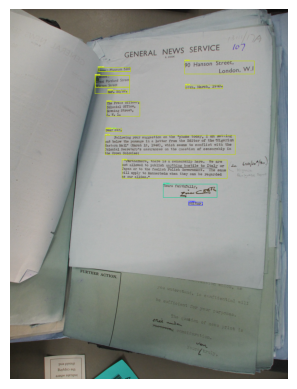

In [7]:
#predict_layout(BASE_PATH + "two_sides_1.JPG", conf=0.09)


raw_p = BASE_PATH + "two_sides_1.JPG"
results = predict_layout(raw_p, conf=0.09, iou=0.5)
extract_bb_crop(results, raw_p)


image 1/1 /home/anup/text_book_seg/text_book_segmentation/data/input/two_sides_hp_2.png: 800x1024 1 Page-footer, 2 Page-headers, 4 Section-headers, 8 Texts, 1042.1ms
Speed: 3.9ms preprocess, 1042.1ms inference, 0.8ms postprocess per image at shape (1, 3, 800, 1024)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[      103.5      572.24      525.13      764.68]
[     631.67      659.61      1054.2      770.38]
[      628.9       156.4      1049.4      364.42]
[     630.74       513.5      1050.8      657.68]
[     110.24      360.26      530.44      568.49]
[     628.25      91.882      1046.3      154.16]
[     277.91       335.9      369.08      352.02]
[     642.57      375.33      1036.7      502.93]
[      297.5      785.62      320.79      797.64]
[     199.89      143.21      466.74      200.69]
[     228.87      95.901      434.04      118.66]
[     720.82      62.304      948.51      72.549]
[     1021.5      59.121      1043.8      70.925]
[     260.69      220.58      392.83      239.82]
[     261.02      220.13      393.02      239.39]
[([[np.int32(47), 0], [np.int32(101), 0], [np.int32(101), np.int32(11)], [np.int32(47), np.int32(11)]], 'dcd inal', np.float64(0.15932787270470256)), ([[np.int32(99), 0], [np.int32(422), 0], [np.int32(422), np.int32(23)], [np.int32(99), np.int32(23)]

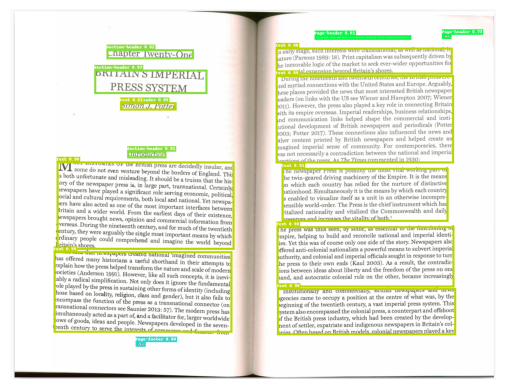

In [8]:
#predict_layout(BASE_PATH + "two_sides_hp_2.png", conf=0.1)

raw_p = BASE_PATH + "two_sides_hp_2.png"
results = predict_layout(raw_p, conf=0.09, iou=0.5)
extract_bb_crop(results, raw_p)